## Gerekli Kütüphanelerin İçe Aktarılması ve Dizinlerin Tanımlanması
Bu hücrede model eğitimi ve veri işleme için gerekli Python kütüphaneleri import edilir ve veri dizinleri tanımlanır.

- **`os`**: Dosya ve dizin işlemleri için.  
- **`seaborn` ve `matplotlib.pyplot`**: Veri görselleştirme için.  
- **`tensorflow` ve `keras` modülleri**: Derin öğrenme modelini oluşturmak, eğitmek ve veri ön işleme için.  
- **`sklearn.metrics`**: Model değerlendirme (classification report ve confusion matrix) için.  
- **`numpy`**: Sayısal işlemler için.  
- **`warnings.filterwarnings('ignore')`**: Gereksiz uyarıları bastırmak için.  
- **`train_dir`, `val_dir`, `test_dir`**: Eğitim, doğrulama ve test veri dizinleri.


In [2]:
import os
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
import numpy as np
import warnings
warnings.filterwarnings('ignore')

train_dir = "/kaggle/input/ship-classification-dataset/ships_dataset/train"
val_dir = "/kaggle/input/ship-classification-dataset/ships_dataset/valid"
test_dir = "/kaggle/input/ship-classification-dataset/ships_dataset/test"

## Veri Dağılımının Görselleştirilmesi
`train_dir` içindeki her sınıfa ait görüntü sayısı hesaplanıyor ve her bir sınıftaki görüntü sayısı hem bar grafiği hem de pasta grafiği ile görselleştiriliyor.  
Bu sayede veri setindeki sınıf dağılımı kolayca incelenebilir.

Dağılıma bakıldığında her class içerisinden neredeyse aynı sayıda (Car Carrier dışında) örnek görüyoruz.

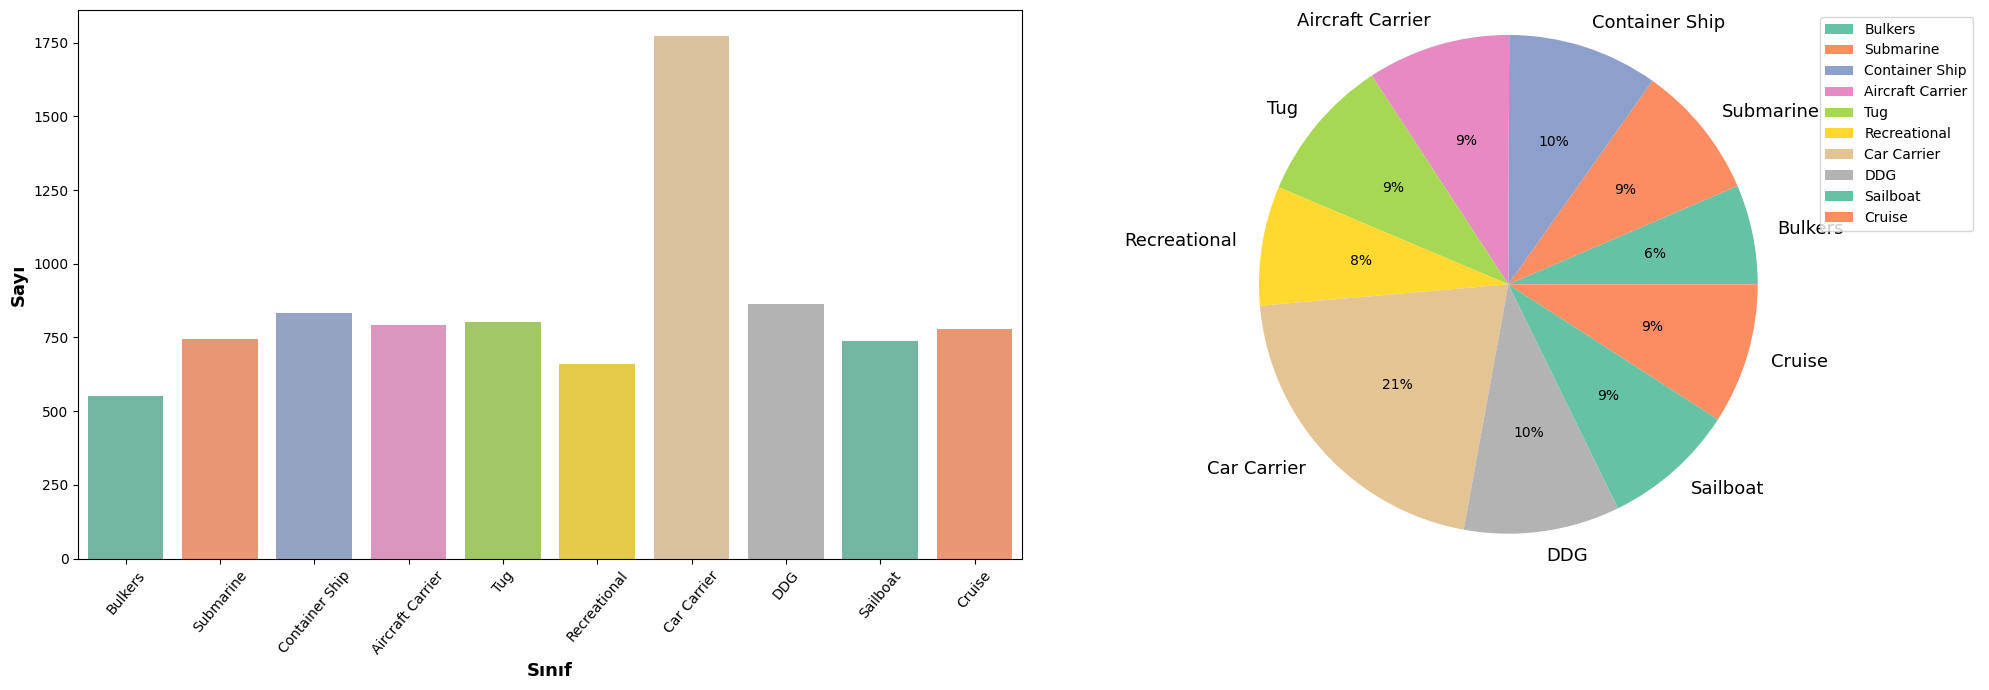

In [3]:
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}

plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='Set2')
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
plt.xlabel('Sınıf', fontsize=13, fontweight='bold', loc='center')
plt.ylabel('Sayı', fontsize=13, fontweight='bold')
plt.xticks(rotation=50)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%.0f%%', colors=sns.color_palette('Set2'))
plt.legend(fontsize='medium')
plt.axis('equal')
plt.tight_layout()

plt.show()

## Veri Ön İşleme için ImageDataGenerator
Bu kısımda eğitim, doğrulama ve test veri setleri için `ImageDataGenerator` nesneleri tanımlanmaktadır.  

- **Eğitim seti (`train_datagen`)**: Yeniden ölçekleme (`rescale`), yatay çevirme (`horizontal_flip`) ve parlaklık artırma/azaltma (`brightness_range`) ile veri artırma (augmentation) uygulanır.  
- **Doğrulama/Test seti (`val_test_datagen`)**: Sadece yeniden ölçekleme (`rescale`) uygulanır, böylece model performansı tarafsız şekilde değerlendirilir.  


In [4]:
img_size = (224, 224)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    brightness_range=[0.9,1.1]
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255,
)

print("Training:")
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=40
)

print("\nValidation:")
val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

print("\nTest:")
test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    class_mode="categorical",
    batch_size = batch_size,
    shuffle= False
)

Training:
Found 8534 images belonging to 10 classes.

Validation:
Found 689 images belonging to 10 classes.

Test:
Found 781 images belonging to 10 classes.


## Eğitim Verisi Görselleştirme
Bu kısımda `train_gen` ile oluşturulan eğitim verilerinden bir batch alınır ve içerisindeki ilk 15 görüntü görselleştirilir.  
Her görüntünün başlığında, ilgili sınıf etiketi gösterilmektedir.

- **`x_batch` ve `y_batch`**: `train_gen` üzerinden alınan görüntü ve sınıf etiketleri.  
- **`idx_to_class`**: Numeric sınıf indekslerini, sınıf isimlerine dönüştürmek için sözlük.  
- **Görselleştirme**: İlk 15 görüntü 3x5 şeklinde bir grid üzerinde gösterilir, her birinin başlığında sınıf adı bulunur.


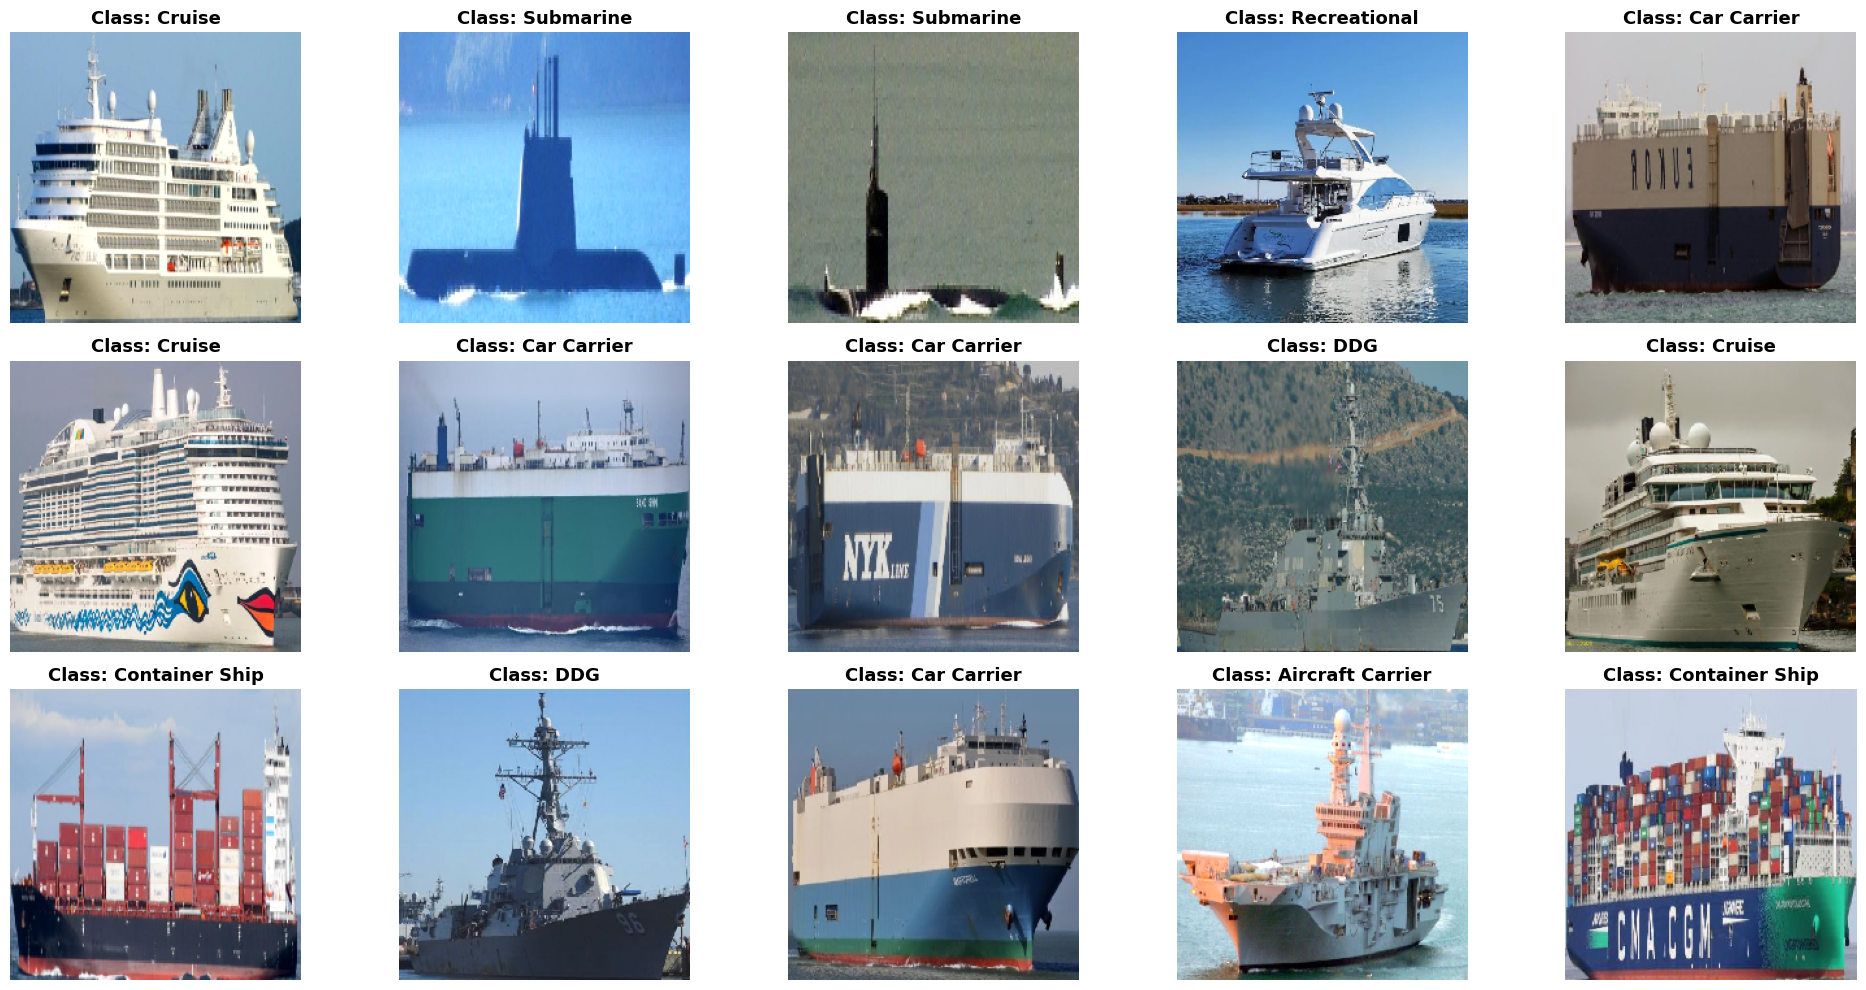

In [5]:
x_batch, y_batch = next(train_gen)
idx_to_class = {v:k for k,v in train_gen.class_indices.items()}

plt.figure(figsize=(20,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(x_batch[i])
    class_idx = np.argmax(y_batch[i])
    plt.title(f"Class: {idx_to_class[class_idx]}", fontweight='bold', fontsize=13)
    plt.axis("off")

plt.tight_layout()
plt.show()

## CNN Modelinin Tanımlanması ve Callback'lerin Ayarlanması
Bu hücrede derin öğrenme modeli ve eğitim sırasında kullanılacak callback'ler oluşturulmaktadır.

- **`num_classes`**: Eğitim veri jeneratöründen alınan sınıf sayısı.  
- **`get_cnn_model` fonksiyonu**: 3 evrişim bloğu ve bir sınıflandırıcı katmandan oluşan CNN modelini döndürür.  
  - **Evrişim blokları (Conv2D + BatchNormalization + MaxPooling2D)**: Özellik çıkarımı için.  
  - **Flatten + Dense + Dropout**: Çıkarılan özellikleri sınıflandırmaya dönüştürür ve overfitting’i azaltır.  
  - **Çıkış katmanı (Dense + softmax)**: Sınıf tahminleri için. L2 regularizasyonu uygulanır.  
- **`EarlyStopping`**: Modelin doğrulama kaybı iyileşmediğinde eğitimi durdurur ve en iyi ağırlıkları geri yükler.  
- **`ReduceLROnPlateau`**: Doğrulama kaybı belirli sayıda epoch iyileşmezse öğrenme oranını azaltır.  
- **`cnn_model`**: Fonksiyon ile oluşturulan CNN modeli.


In [6]:
num_classes = train_gen.num_classes

results = {}

def get_cnn_model(dropout_rate=0.5):
    model = models.Sequential([
    # İlk evrişim bloğu
    Input(shape=(224,224,3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # İkinci evrişim bloğu
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Üçüncü evrişim bloğu
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Sınıflandırıcı
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(dropout_rate),
    layers.Dense(num_classes, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))
    ])
    return model

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

## Eğitim Sonuçlarının Değerlendirilmesi
Bu hücrede modelin eğitim süreci ve doğrulama sonuçları özetlenmiştir.

- Model, 20 epoch boyunca eğitilmiş ve `EarlyStopping` ile en iyi ağırlıklar korunmuştur.  
- Eğitim doğruluğu (`accuracy`) neredeyse 1.0 seviyesine ulaşırken, doğrulama doğruluğu (`val_accuracy`) 0.9376 ile yüksek bir performans göstermektedir.  
- **Hiperparametre Sonucu**: Öğrenme hızı 0.001 ve batch size 64 için elde edilen en iyi doğrulama doğruluğu `0.9376`.  
- Öğrenme sürecinde **overfitting** riski görülse de, `ReduceLROnPlateau` ve `EarlyStopping` sayesinde kontrol altında tutulmuştur.


In [8]:
cnn_model = get_cnn_model()

cnn_model.compile(
optimizer = keras.optimizers.Adam(learning_rate=0.001),
loss='categorical_crossentropy',
metrics=['accuracy']
)

history = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, reduce_lr],
)


results[f'lr_0.001_bs_{batch_size}'] = history.history['val_accuracy'][-1]

print("Hiperparametre sonuçları:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 131s 912ms/step - accuracy: 0.5383 - loss: 1.6718 - val_accuracy: 0.0160 - val_loss: 3.6189 - learning_rate: 0.0010
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 398ms/step - accuracy: 0.8548 - loss: 0.6098 - val_accuracy: 0.0464 - val_loss: 3.4217 - learning_rate: 0.0010
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 50s 374ms/step - accuracy: 0.9214 - loss: 0.3897 - val_accuracy: 0.3861 - val_loss: 1.7355 - learning_rate: 0.0010
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 51s 381ms/step - accuracy: 0.9573 - loss: 0.2741 - val_accuracy: 0.7605 - val_loss: 0.8260 - learning_rate: 0.0010
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 51s 382ms/step - accuracy: 0.9735 - loss: 0.2135 - val_accuracy: 0.8607 - val_loss: 0.5130 - learning_rate: 0.0010
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 392ms/step - accuracy: 0.9877 - loss: 0.1632 - val_accuracy: 0.8737 - val_loss: 0.5146 - learning_rate: 0.0010
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 385ms/step - accuracy: 0.

## Eğitim ve Doğrulama Performans Grafikleri
Bu hücrede modelin eğitim süresince doğruluk ve kayıp değerleri görselleştirilmiştir.

- **Sol Grafik (Accuracy)**: Her epoch'taki eğitim ve doğrulama doğruluk değerleri.  
  - Mavi: Eğitim doğruluğu  
  - Turuncu: Doğrulama doğruluğu  
- **Sağ Grafik (Loss)**: Her epoch'taki eğitim ve doğrulama kayıp değerleri.  
  - Mavi: Eğitim kaybı  
  - Turuncu: Doğrulama kaybı  

Bu grafikler, modelin öğrenme sürecini görselleştirerek overfitting veya underfitting durumlarını analiz etmeye yardımcı olur.

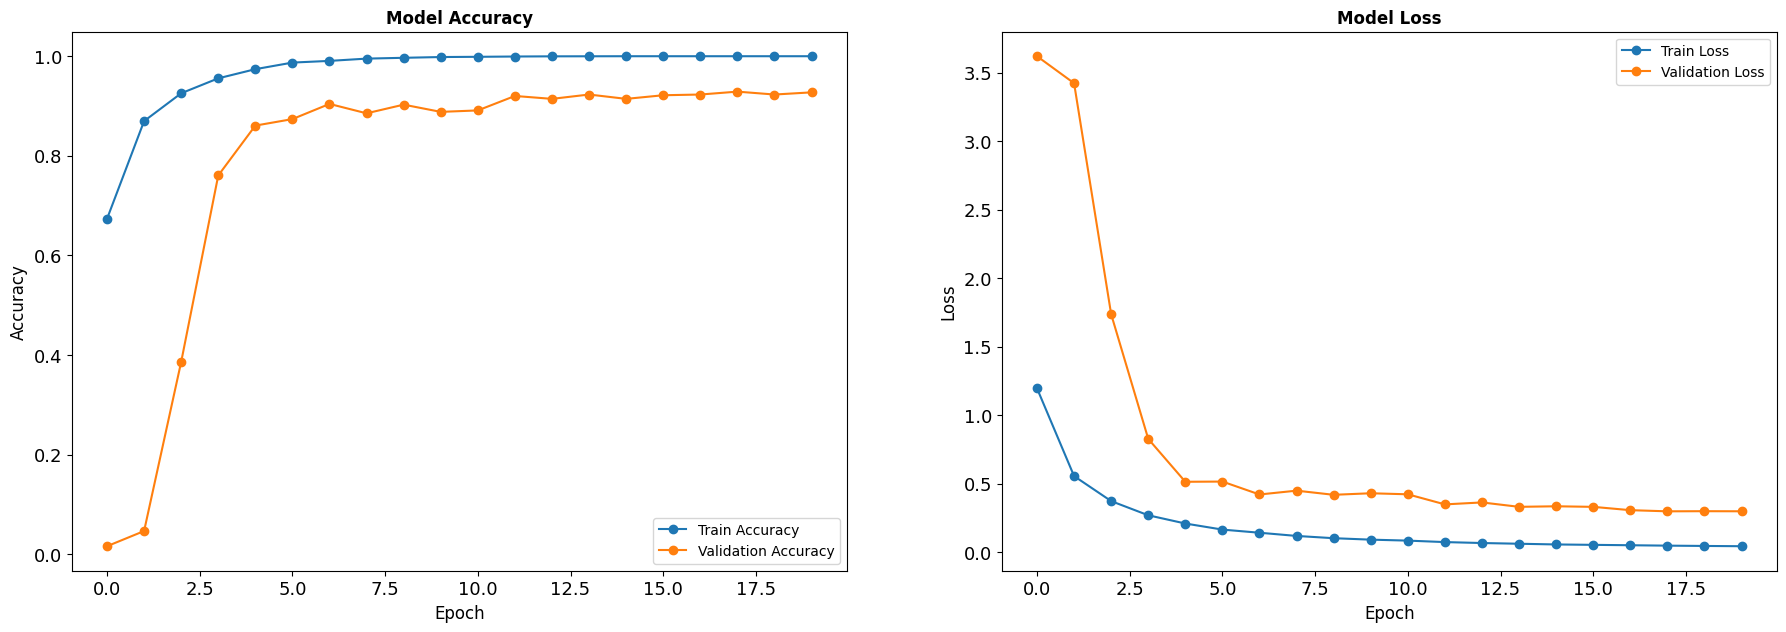

In [9]:
import matplotlib.pyplot as plt

# Accuracy grafiği
plt.figure(figsize=(22,7))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o' )
plt.title('Model Accuracy', fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss', fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.show()


## Test Seti Üzerinde Confusion Matrix
Bu hücrede modelin test seti üzerindeki performansı, sınıflar bazında görselleştirilmiştir.

- **`y_true`**: Test veri setinin gerçek sınıf etiketleri.  
- **`y_pred`**: Model tarafından tahmin edilen sınıf indeksleri.  
- **`confusion_matrix`**: Gerçek ve tahmin edilen sınıfları karşılaştırarak modelin hangi sınıflarda başarılı veya başarısız olduğunu gösterir.  
- **Görselleştirme**: Seaborn ile ısı haritası kullanılarak, her sınıfın tahmin doğrulukları ve hataları net bir şekilde gösterilir.

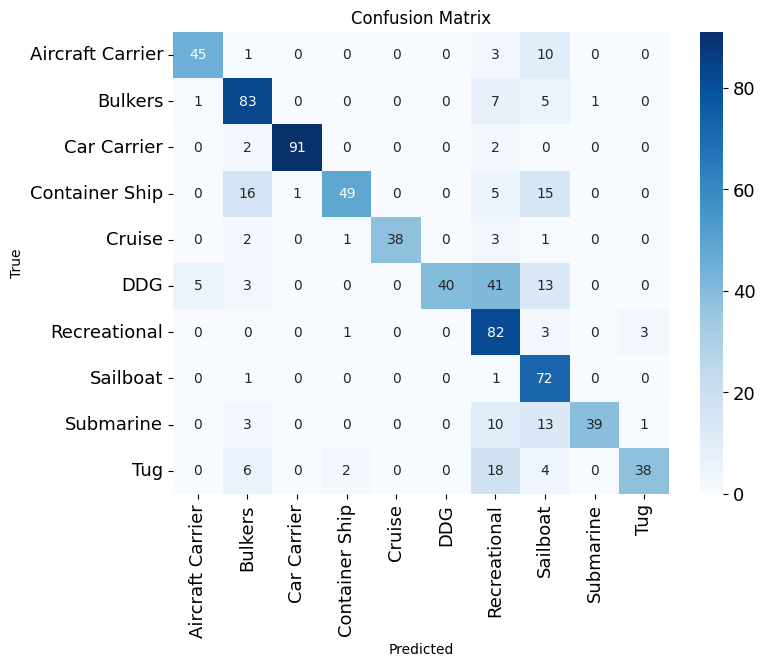

In [10]:
y_true = test_gen.classes  # gerçek etiketler
y_pred_probs = cnn_model.predict(test_gen, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)  # tahmin edilen sınıf indexleri

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Class isimlerini al
class_names = list(test_gen.class_indices.keys())

# Görselleştir
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## 🔹 Doğru ve Yanlış Tahmin Örnekleri

Bu görselleştirme, test setinden **doğru ve yanlış tahmin edilmiş örnekleri** göstermektedir.  

- İlk satırda, modelin doğru tahmin ettiği 4 örnek yer alıyor.  
- İkinci satırda ise, modelin yanlış tahmin ettiği 4 örnek gösterilmektedir.  
- Her görselin başlığı, modelin tahmin ettiği sınıf ve gerçek sınıfı içerir.  

Bu görseller sayesinde modelin hangi durumlarda başarılı olduğu ve hangi durumlarda hata yaptığı kolayca anlaşılabilir.


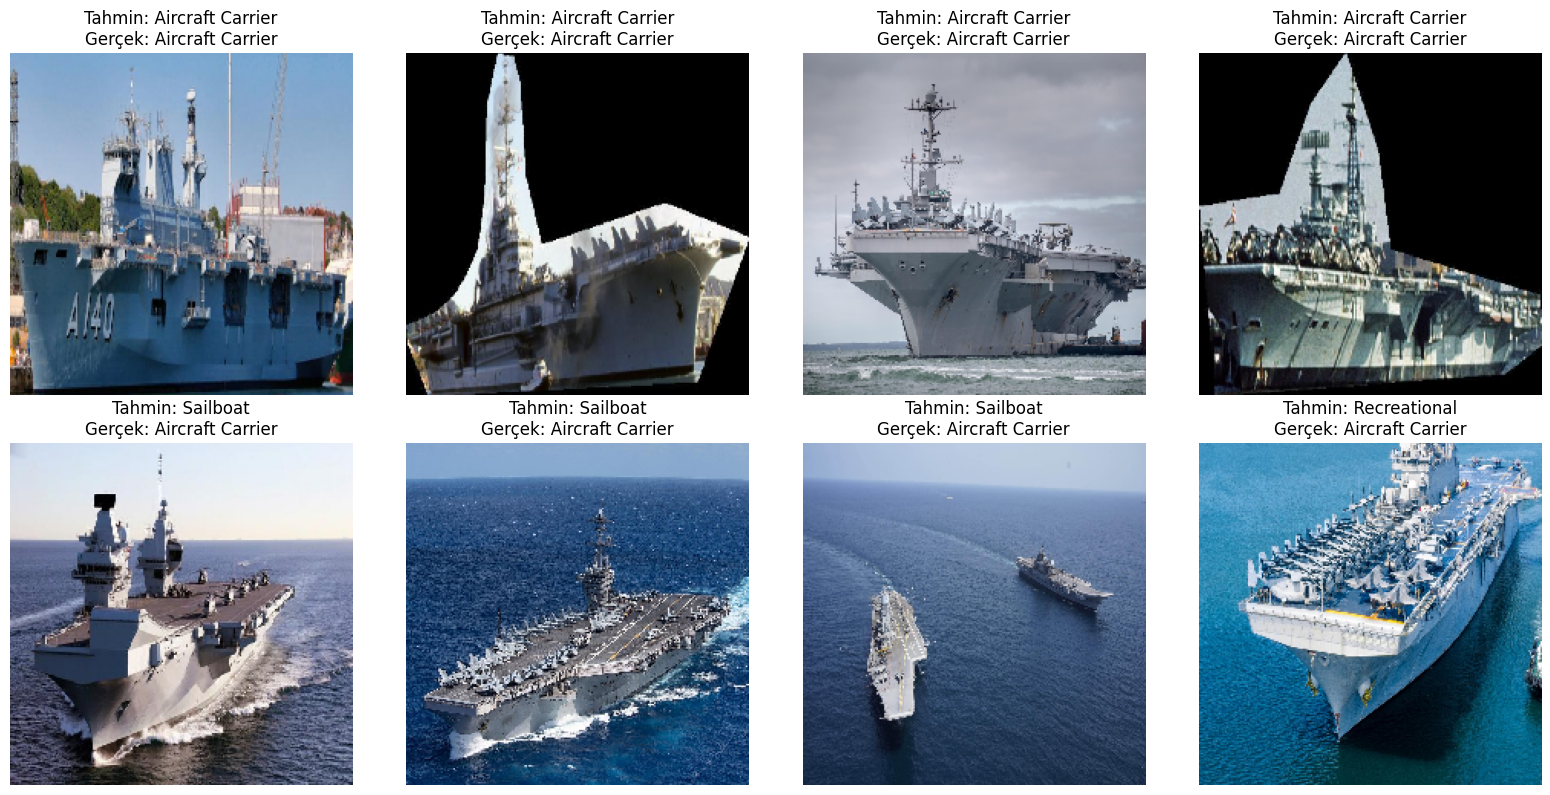

In [11]:
# Tahminleri al
y_true = test_gen.classes
y_pred_probs = cnn_model.predict(test_gen, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
class_names = list(test_gen.class_indices.keys())

# Doğru ve yanlış tahminleri belirle
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

# Görselleştirme
plt.figure(figsize=(16, 8))

# Doğru tahminler
for i, idx in enumerate(correct_indices[:4]):
    img_path = test_gen.filepaths[idx]
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"Tahmin: {class_names[y_pred_classes[idx]]}\nGerçek: {class_names[y_true[idx]]}")
    plt.axis('off')

# Yanlış tahminler
for i, idx in enumerate(incorrect_indices[:4]):
    img_path = test_gen.filepaths[idx]
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 4, i+5)
    plt.imshow(img)
    plt.title(f"Tahmin: {class_names[y_pred_classes[idx]]}\nGerçek: {class_names[y_true[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Test Seti Üzerinde Sınıflandırma Raporu
Bu hücrede modelin test veri seti üzerindeki sınıf bazlı performansı değerlendirilmiştir.

- **`y_true`**: Test setinin gerçek sınıf etiketleri.  
- **`y_pred`**: Modelin tahmin ettiği sınıf etiketleri.  
- **`classification_report`**: Precision, Recall, F1-score ve support değerlerini sınıf bazında gösterir.  
  - **Precision**: Modelin doğru tahmin ettiği örneklerin oranı.  
  - **Recall**: Gerçek sınıflardan modelin doğru tahmin ettiği oran.  
  - **F1-score**: Precision ve Recall’un harmonik ortalaması.  
  - **Support**: Her sınıfta kaç örnek bulunduğu.  

Bu rapor, hangi sınıflarda modelin güçlü veya zayıf olduğunu anlamaya yardımcı olur.


In [12]:
# 1. Test verisinden tüm görüntüleri ve etiketleri al
y_true = test_gen.classes  # gerçek etiketler
class_labels = list(test_gen.class_indices.keys())

# 2. Model ile tahmin yap
y_pred_probs = cnn_model.predict(test_gen, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Sınıflandırma Raporu:\n", report)


Sınıflandırma Raporu:
                   precision    recall  f1-score   support

Aircraft Carrier       0.88      0.76      0.82        59
         Bulkers       0.71      0.86      0.78        97
     Car Carrier       0.99      0.96      0.97        95
  Container Ship       0.92      0.57      0.71        86
          Cruise       1.00      0.84      0.92        45
             DDG       1.00      0.39      0.56       102
    Recreational       0.48      0.92      0.63        89
        Sailboat       0.53      0.97      0.69        74
       Submarine       0.97      0.59      0.74        66
             Tug       0.90      0.56      0.69        68

        accuracy                           0.74       781
       macro avg       0.84      0.74      0.75       781
    weighted avg       0.83      0.74      0.74       781



## Grad-CAM İçin Gerekli Kütüphaneler
Bu hücrede, CNN modelinin hangi bölgelerine dikkat ettiğini görselleştirmek için Grad-CAM yöntemi kullanılacaktır.

- **`tf_keras_vis`**: Keras modelleri için Grad-CAM ve diğer görselleştirme tekniklerini sağlar.  
- **`tensorflow.keras.preprocessing.image`**: Görüntüleri modele uygun hale getirmek için kullanılır.  
- **`Gradcam`**: Grad-CAM görselleştirmesi oluşturmak için ana sınıf.  
- **`CategoricalScore`**: Belirli bir sınıf için modelin skorunu hesaplamaya yarar.  

> Not: Bu kütüphaneler, modelin tahmin ettiği sınıf bazında dikkat haritalarını çıkarmak için gereklidir.

In [13]:
!pip install tf_keras_vis
from tensorflow.keras.preprocessing import image
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.1 MB/s eta 0:00:00a 0:00:01


## Grad-CAM Görselleştirmesi
Bu hücrede, CNN modelinin test görüntüleri üzerindeki dikkat haritaları Grad-CAM yöntemi ile görselleştirilir.

- Modelin son Conv2D katmanı belirlenir.  
- İlk 10 test görüntüsü için Grad-CAM hesaplanır.  
- Orijinal görüntü ve dikkat haritası üst üste çizilerek modelin hangi bölgelere odaklandığı görselleştirilir.


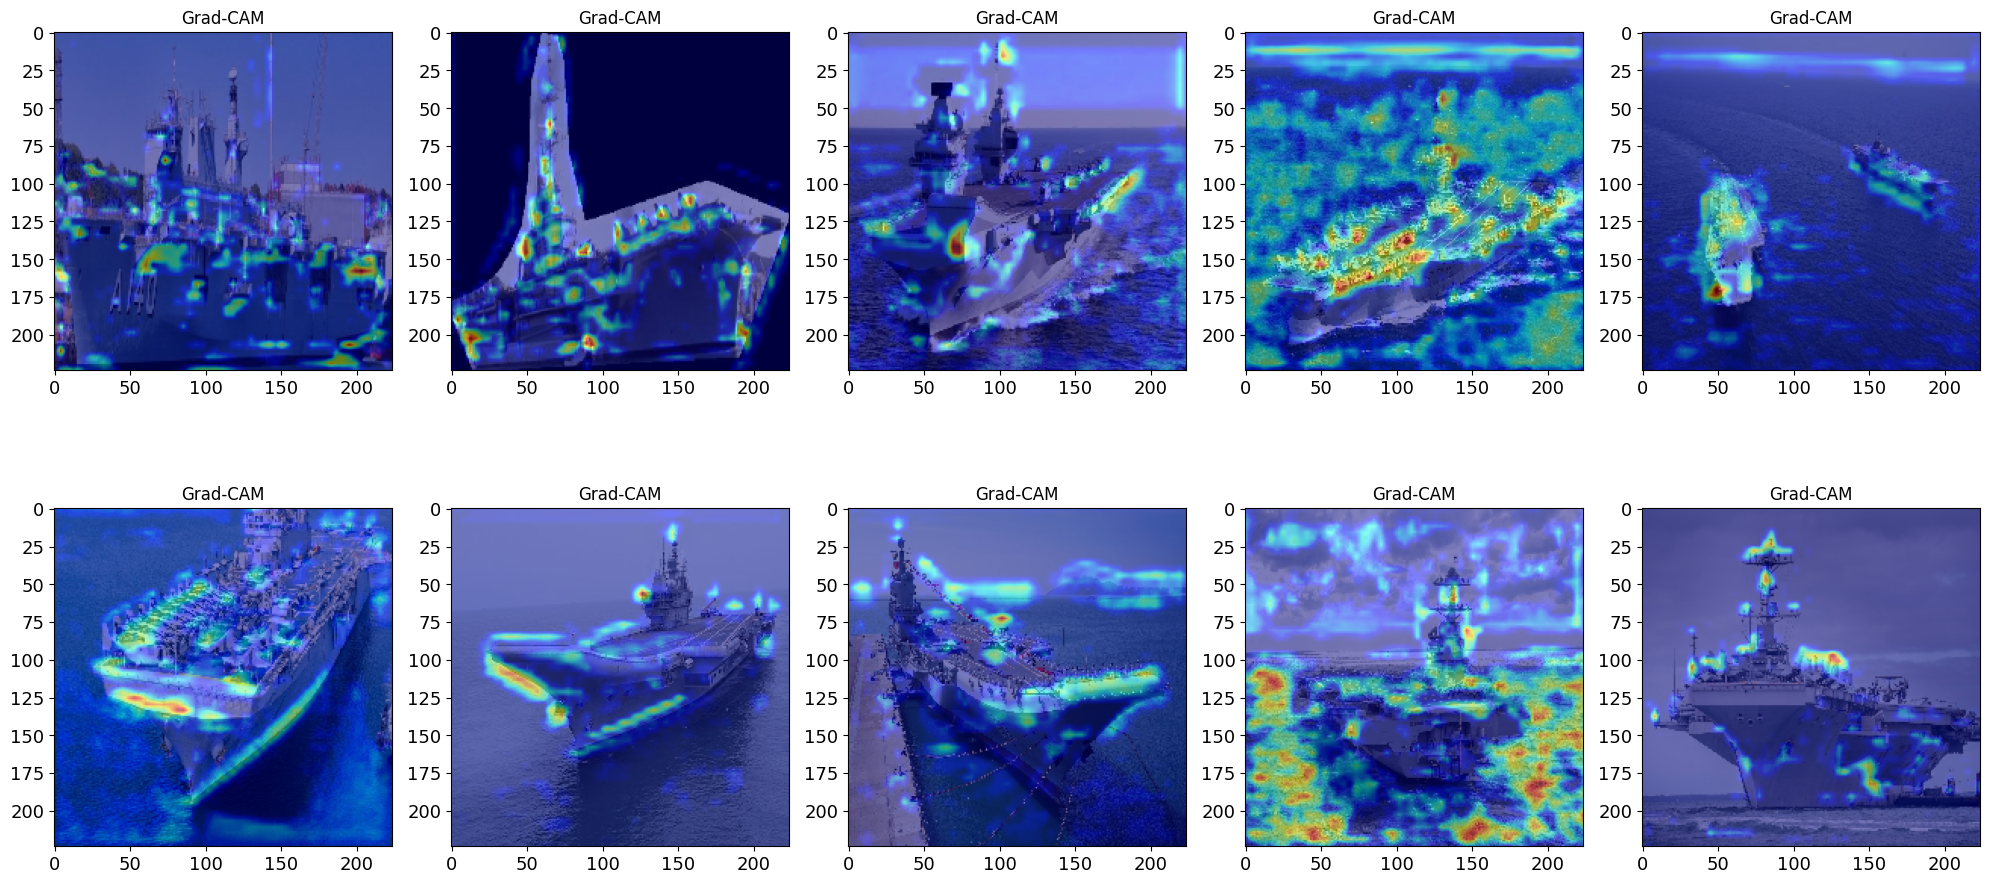

In [14]:
# Build the 
_ = cnn_model.predict(np.zeros((1, *img_size, 3)), verbose=0)

# Find the last Conv2d layer
last_conv_idx = None
for i, layer in enumerate(cnn_model.layers):
    if 'conv' in layer.name.lower():
        last_conv_idx = i

# Grad-CAM object
gradcam = Gradcam(cnn_model)

# İlk 10 görsel için Grad-CAM üret
plt.figure(figsize=(20,10))
for idx in range(10):
    img_path = test_gen.filepaths[idx]
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0

    # Tahmin sınıfı
    pred = cnn_model.predict(x, verbose=0)
    pred_class = np.argmax(pred[0])

    # Grad-CAM
    score = CategoricalScore(pred_class)
    cam = gradcam(score, x, penultimate_layer=last_conv_idx)

    # Normalize et
    heatmap = np.uint8(255 * (cam[0] - cam[0].min()) / (cam[0].max() - cam[0].min()))

    plt.subplot(2,5,idx+1)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM")

plt.tight_layout()
plt.show()


## Test Verisi Üzerinde Model Değerlendirmesi
Bu hücrede, CNN modelinin test veri seti üzerindeki genel performansı ölçülmektedir.

- **`evaluate`**: Test seti için kayıp (`loss`) ve doğruluk (`accuracy`) değerlerini döndürür.  
- **`score`**: Test kaybı ve doğruluk değerleri saklanır ve ekrana yazdırılır.


In [15]:
# Test evaluation
test_gen.reset()
score = cnn_model.evaluate(test_gen, verbose=1)
print(f"For test data set; Loss: {score[0]:.4f}  Accuracy: {score[1]:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 432ms/step - accuracy: 0.7726 - loss: 1.0399
For test data set; Loss: 1.1731  Accuracy: 0.7388


## Dropout Hiperparametresi Denemeleri
Bu hücrede farklı dropout oranları ile model eğitilmiş ve doğrulama doğrulukları karşılaştırılmıştır.

- **`dropout_r`**: 0.5'den farklı olarak 0.4 ve 0.6 değerleri denenmiştir.  
- Her dropout oranı için:  
  1. Model yeniden oluşturulur ve compile edilir.  
  2. 10 epoch boyunca eğitim yapılır (`EarlyStopping` ve `ReduceLROnPlateau` callback’leri kullanılır).  
  3. Son epoch’taki doğrulama doğruluğu `results` sözlüğüne kaydedilir.  

- **Hiperparametre Sonuçları**: Her dropout oranının doğrulama performansı ekrana yazdırılır ve hangi oranın daha iyi olduğunu görmeyi sağlar.


In [18]:
results = {}
scores = {}
for rate in [0.4, 0.6]:
    cnn_model = get_cnn_model(rate)

    print("Dropout:", rate)
    cnn_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )
    
    history = cnn_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=[early_stop, reduce_lr],
    )

    results[f'dr_{rate}'] = history.history['val_accuracy'][-1]

    test_gen.reset()
    scores[f'dr_{rate}'] = cnn_model.evaluate(test_gen, verbose=1)
    

print("Hiperparametre sonuçları:")
for key, value in results.items():
    print(f"{key}_val_accuracy: {value:.4f}")


for key, value in scores.items():
    print(f"For test data set; {key}_test, Loss: {value[0]:.4f}  Accuracy: {value[1]:.4f}")

Dropout: 0.4
Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 61s 397ms/step - accuracy: 0.5723 - loss: 1.5827 - val_accuracy: 0.0218 - val_loss: 3.3552 - learning_rate: 0.0010
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 394ms/step - accuracy: 0.8877 - loss: 0.5169 - val_accuracy: 0.1190 - val_loss: 2.8755 - learning_rate: 0.0010
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 392ms/step - accuracy: 0.9444 - loss: 0.3335 - val_accuracy: 0.3556 - val_loss: 1.8471 - learning_rate: 0.0010
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 391ms/step - accuracy: 0.9692 - loss: 0.2342 - val_accuracy: 0.8142 - val_loss: 0.6841 - learning_rate: 0.0010
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 393ms/step - accuracy: 0.9865 - loss: 0.1702 - val_accuracy: 0.8389 - val_loss: 0.5943 - learning_rate: 0.0010
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 51s 377ms/step - accuracy: 0.9926 - loss: 0.1377 - val_accuracy: 0.8592 - val_loss: 0.5696 - learning_rate: 0.0010
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 51s 378ms/step - 